# 4.3 Cluster wheel movements

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh
from scipy.signal import savgol_filter

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
# from one_functions_generic import prepro
from design_functions import wheel_velocity
from data_processing import interpolate
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [2]:
bin_size = 0.1
multiplier = 1/bin_size

response_threshold = 0.3 # radians
velocity_threshold = 100 # degrees/s
monotonic_threshold = -.0005  # TODO: should validate more methodically

## Get data

In [3]:
# Load preprocessed data
results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//4_analyses/'
results_path = '/home/ines/repositories/representation_learning_variability//Models/Sub-trial//4_analyses/'

os.chdir(results_path)
states_trial_type = pickle.load(open("states_trial_type.pkl", "rb"))

In [4]:

eids = np.unique(states_trial_type['session'])
all_mice_stacked_movements = np.array([])
mouse_movements_df = pd.DataFrame()
all_movement_info = pd.DataFrame(columns=['eid', 'trial_epoch', 'feedback', 'choice', 'signed_contrast'])

for e, eid in enumerate(eids[:10]):

    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    # Find movements
    df = states_trial_type[['Bin', 'mouse_name', 'session', 'identifiable_states',
                            'label', 'contrast', 'correct', 'choice']].copy()
    df = df.loc[(df['session']==eid)].sort_values(by='Bin')
    check_states = np.array(df['identifiable_states'])
    on = [s[0] == '1' for s in check_states]
    df['wheel_on'] = np.zeros(len(df))
    df['wheel_on'][on] = 1
    df['dif'] = np.zeros(len(df)) * np.nan
    df['dif'][1:] = np.diff(df['wheel_on'])
    movement_onsets = np.array(df.loc[df['dif']==1., 'Bin']) + 1
    movement_offsets = np.array(df.loc[df['dif']==-1., 'Bin'])

    # Initialize
    
    # movement_info = pd.DataFrame(columns=['trial_epoch', 'feedback', 'choice', 'signed_contrast'])
    
    stacked_movements = np.array([])
    
    # Calculate per movement
    for m, onset in enumerate(movement_onsets[:-1]):
        
        if movement_offsets[m] < onset:
            offset = movement_offsets[m+1]
        else:
            offset = movement_offsets[m]
        
        if offset - onset > 0.2:
            
            movement_pos = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel position']
            movement_times = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                        & (wheel_vel['Bin']<offset), 'Wheel times']
            
            # time_interval = (offset - onset) * .1 # convert from Bins to seconds
            movement_pos_deg = movement_pos * 180 / np.pi # convert from radians to degrees
            movement_velocity = np.diff(movement_pos_deg) /  np.diff(movement_times)
            norm_movement_pos = np.array(movement_pos) - np.array(movement_pos)[0]

            # Interpolate values at new grid coordinates
            rescaled_array = interpolate(np.array(movement_times)[1:], movement_velocity, size=100, plot=False)
            
            # Save data and metadata
            if len(df.loc[(df['Bin']>=onset) & (df['Bin']<offset)]) > 0:
                
                movement = pd.DataFrame(columns=['eid', 'trial_epoch', 'feedback', 'choice', 'signed_contrast'], index=[0])
                movement['eid'][0] = eid
                movement['trial_epoch'][0] = str(np.unique(list(df.loc[(df['Bin']>=onset)
                                            & (df['Bin']<offset), 'label'])))

                movement['feedback'][0] = list(df.loc[(df['Bin']>=onset)
                                            & (df['Bin']<offset), 'correct'])[0]
                movement['choice'][0] =  list(df.loc[(df['Bin']>=onset)
                                            & (df['Bin']<offset), 'choice'])[0]
                movement['signed_contrast'][0] =  list(df.loc[(df['Bin']>=onset)
                                            & (df['Bin']<offset), 'contrast'])[0]
                
                if len(stacked_movements) == 0:
                    stacked_movements = rescaled_array
                    movement_info = movement
                else:
                    stacked_movements = np.vstack((stacked_movements, rescaled_array))
                    movement_info = movement_info.append(movement)
                    
    if len(all_movement_info) == 0:
        all_movement_info = movement_info
        all_mice_stacked_movements = stacked_movements
    else:
        all_mice_stacked_movements = np.vstack((all_mice_stacked_movements, stacked_movements))
        all_movement_info = all_movement_info.append(movement_info)

/tmp/ipykernel_20136/131939088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/tmp/ipykernel_20136/131939088.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/tmp/ipykernel_20136/131939088.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  movement_info = movement_info.append(movement)
/tmp/ipykernel_20136/131939088.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mo

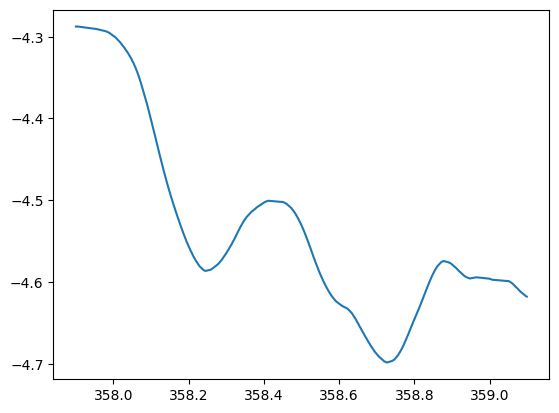

In [127]:
plt.plot(movement_times, movement_pos)

## UMAP

In [7]:
reducer = umap.UMAP(random_state= 42)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(all_mice_stacked_movements)

embedding = reducer.fit_transform(all_mice_stacked_movements)
embedding.shape

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(1658, 2)

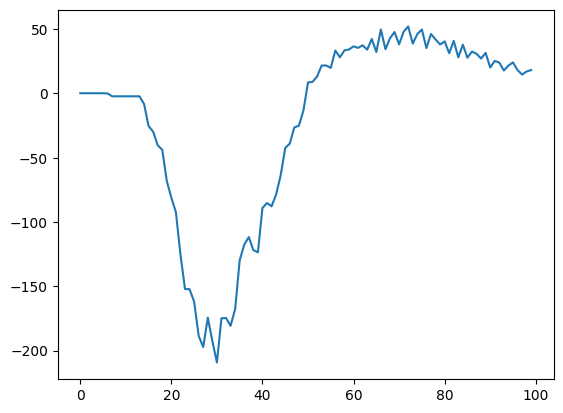

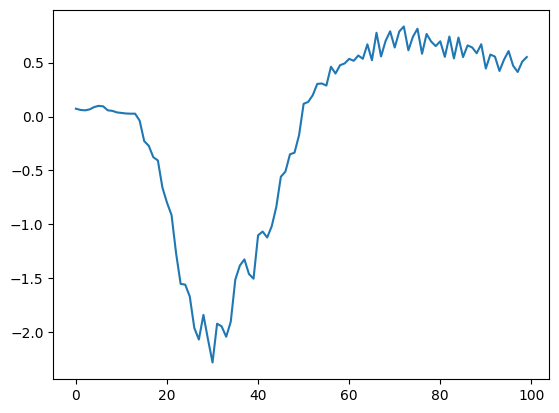

In [8]:
plt.plot(all_mice_stacked_movements.T[:, 1])
plt.show()
plt.plot(standardized_X.T[:, 1])

In [9]:
merged_df = all_movement_info
merged_df['UMAP1'] = embedding[:, 0]
merged_df['UMAP2'] = embedding[:, 1]

In [13]:
merged_df.trial_epoch.unique()

array(["['Pre-quiescence']", "['ITI' 'Right choice' 'Stimulus left']",
       "['ITI' 'nan']", "['ITI']", "['Right choice' 'Stimulus right']",
       "['Right choice']", "['ITI' 'Right choice']",
       "['Right choice' 'nan']", "['Pre-quiescence' 'nan']",
       "['Right choice' 'Stimulus left']",
       "['ITI' 'Quiescence' 'Right choice']",
       "['ITI' 'Right choice' 'Stimulus right']",
       "['ITI' 'Pre-quiescence' 'nan']",
       "['Pre-quiescence' 'Quiescence']",
       "['ITI' 'Left choice' 'Stimulus right']", '[nan]',
       "['Quiescence' 'Right choice']", "['ITI' 'Right choice' 'nan']",
       "['ITI' 'Stimulus left']", "['ITI' 'Left choice' 'Quiescence']",
       "['Left choice' 'Stimulus right']", "['Left choice']",
       "['ITI' 'Left choice']", "['Left choice' 'Quiescence']",
       "['ITI' 'Left choice' 'Stimulus left']",
       "['ITI' 'Left choice' 'nan']", "['Stimulus left']",
       "['Left choice' 'Stimulus left']", "['Quiescence']",
       "['ITI' 'Pre-quiesc

In [15]:
merged_df.loc[(merged_df['trial_epoch'].isin(["['Left choice']", "['Right choice']"]))]

,eid,trial_epoch,feedback,choice,signed_contrast,UMAP1,UMAP2
0,03063955-2523-47bd-ae57-f7489dd40f15,['Right choice'],0.0,right,0.0625,7.175296,15.771350
0,03063955-2523-47bd-ae57-f7489dd40f15,['Right choice'],0.0,right,0.125,9.718005,11.921936
0,03063955-2523-47bd-ae57-f7489dd40f15,['Right choice'],1.0,right,0.0625,9.502470,12.226214
0,03063955-2523-47bd-ae57-f7489dd40f15,['Right choice'],0.0,right,0.125,4.510668,14.614055
0,03063955-2523-47bd-ae57-f7489dd40f15,['Right choice'],1.0,right,0.125,7.641668,13.306068
...,...,...,...,...,...,...,...
0,111c1762-7908-47e0-9f40-2f2ee55b6505,['Right choice'],1.0,right,0.125,6.520108,14.581228
0,1191f865-b10a-45c8-9c48-24a980fd9402,['Left choice'],0.0,left,0.0,6.672355,12.459945
0,1191f865-b10a-45c8-9c48-24a980fd9402,['Left choice'],0.0,left,0.0,7.032640,12.022616
0,1191f865-b10a-45c8-9c48-24a980fd9402,['Left choice'],0.0,left,0.0,4.079298,16.603701


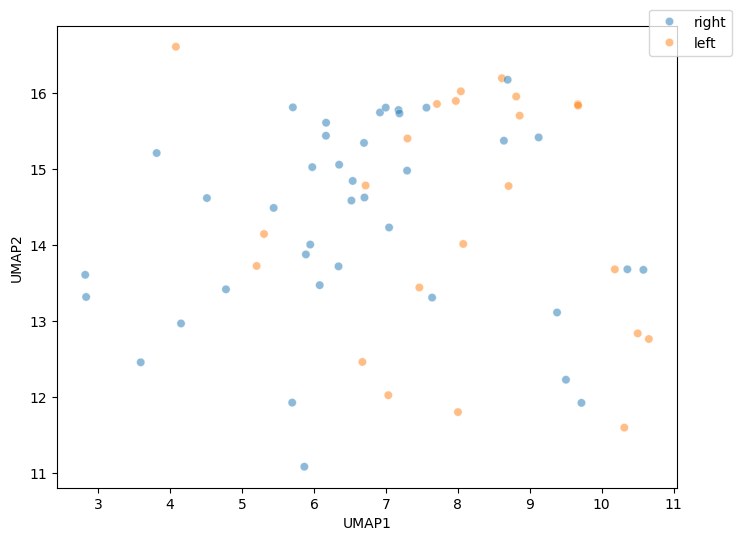

In [16]:
plt.figure(figsize=(8, 6))

use_data = merged_df.loc[(merged_df['trial_epoch'].isin(["['Left choice']", "['Right choice']"]))]
# use_data = merged_df
sns.scatterplot(x='UMAP1', y='UMAP2', hue='choice', data=use_data, alpha=0.5)
plt.legend(bbox_to_anchor=(1.1, 1.05))


## K-means clustering of data

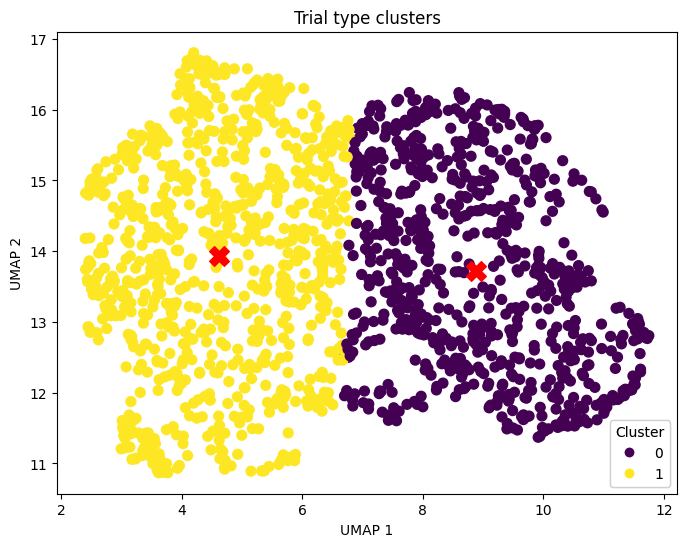

In [11]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans = KMeans(n_clusters=2, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
centroids = kmeans.cluster_centers_
dots = ax.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster")
ax.add_artist(legend1)

plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()